## Ajuste de parámetros R0 y beta del modelo SEIR (Versión probabilística)



Basado en la implementación de SEIR de Eduardo H. Ramirez


Se basa también en el siguiente trabajo de ajuste de parámetros por mínimos cuadrados (Eduardo Ramirez)

https://colab.research.google.com/drive/1mhRUkpmttCNgTPq6DYs6xn1tF3V82q45

**Referencia PyMC3**

https://docs.pymc.io/notebooks/ODE_API_introduction.html

OJO: Requiere actualizar a PyMC 3.8


In [0]:
# El modulo ode viene en 3.8
#!pip install pymc3==3.8

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#cd drive/My\ Drive/

In [0]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')
import math

In [0]:
#Datos Nacionales
my_data=pd.read_excel('Covid_Nacional_Mexico.xlsx', sheet_name='Datos', skiprows=0)
my_data

,Fecha,Casos,Recuperados (%),Recuperados,def,Unnamed: 5,Unnamed: 6
0,2020-02-28,3,NaN,NaN,NaN,NaN,NaN
1,2020-02-29,4,NaN,NaN,NaN,NaN,NaN
2,2020-03-01,5,NaN,NaN,NaN,NaN,NaN
3,2020-03-02,5,NaN,NaN,NaN,NaN,NaN
4,2020-03-03,5,NaN,NaN,NaN,NaN,NaN
5,2020-03-04,5,NaN,NaN,NaN,NaN,NaN
6,2020-03-05,5,NaN,NaN,NaN,NaN,NaN
7,2020-03-06,6,NaN,NaN,NaN,NaN,NaN
8,2020-03-07,7,NaN,NaN,NaN,NaN,NaN
9,2020-03-08,7,NaN,NaN,NaN,NaN,NaN


In [0]:
I_R=my_data[['Fecha','Casos', 'Recuperados']][13:30]
I_R['Recuperados']=round(I_R['Recuperados']).astype(int)
IR=I_R.reset_index(drop=True) 
IR

,Fecha,Casos,Recuperados
0,2020-03-12,15,1
1,2020-03-13,16,1
2,2020-03-14,41,2
3,2020-03-15,53,3
4,2020-03-16,82,3
5,2020-03-17,93,3
6,2020-03-18,118,3
7,2020-03-19,164,3
8,2020-03-20,203,3
9,2020-03-21,251,5


In [0]:
"""
def SEIR(y, t, p):
  alpha,beta,gamma = p
  S, E, I, R = y
  ds = -beta*S*I
  de = beta*S*I - alpha*E
  di = alpha*E - gamma*I
  dr = gamma*I
  return [ds, de, di, dr]

alpha = p[0]
beta = p[1]
gamma = p[2]

S = y[0]
E = y[1]
I = y[2]

"""

##    Modelo
# R0: tasa básica de reproducción 
# alpha: es el inverso del periodo de incubación
# beta: tasa promedio de contagio
# gamma: la tasa de recuperación que representa dicho virus.
## Sintaxis PyMC3 

def SEIR(y, t, p):
    ds = -p[1]*y[0]*y[2]
    de = p[1]*y[0]*y[2] - p[0]*y[1]
    di = p[0]*y[1] - p[2]*y[2]
    dr = p[2]*y[2]
    return [ds, de, di, dr]


In [0]:
# Observaciones (I)


## Condiciones iniciales (porcentuales)
Pop = 126577691  # Mexico Nacional https://es.wikipedia.org/wiki/Demograf%C3%ADa_de_M%C3%A9xico
I_o = IR['Casos'][0] / Pop  # Tenemos 32 casos
E_o = (IR['Casos'][0]*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado


#Estados del modelo SEIR por día
def SEIR_Day(i,r):
  """ 
  Produce los datos normalizados de S,E,I,R dados I y R del dia.
  """
  I = i / Pop
  E = (i*4) / Pop # Ojo aca con el 4
  S = 1 - (E*I)
  R = r / Pop
  return [S, E, I, R]



In [0]:
#Estados del modelo SEIR de los datos nacionales
yobsn=[]
for i in range(0, len(IR)):
    yobsn.append(SEIR_Day(IR['Casos'][i], IR['Recuperados'][i]))

yobs=np.array(yobsn)

In [0]:
obs_times=np.arange(0,yobs.shape[0],1)
obs_times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [0]:
## Times equiparar al yobs
seir_model = DifferentialEquation(
    func=SEIR,
    times=obs_times,
    n_states=4,
    n_theta=3,
)

In [0]:

with pm.Model() as model4:

    #Distribution prior
    sigma = pm.HalfCauchy('sigma', 2.5e-6, shape=4)
    p_alpha = 0.2  # Inverso, entre cero y uno
    p_gamma = pm.Bound(pm.Normal, lower=0.45, upper=0.7)("gamma",0.5,0.05)  # Tasa, entre cero y uno
    p_beta = pm.Normal('beta', 1.75,0.05)
    R0=pm.Deterministic('R0', p_beta/p_gamma)


    #Model
    seir_curves = seir_model(y0=[S_o,E_o,I_o,R_o], theta=[p_alpha, p_beta, p_gamma])
    Y = pm.Normal('Y', mu=seir_curves, sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000,tune=500, target_accept=0.95, cores=2)
    #posterior
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma, sigma]
100%|██████████| 2000/2000 [01:50<00:00, 18.10it/s]


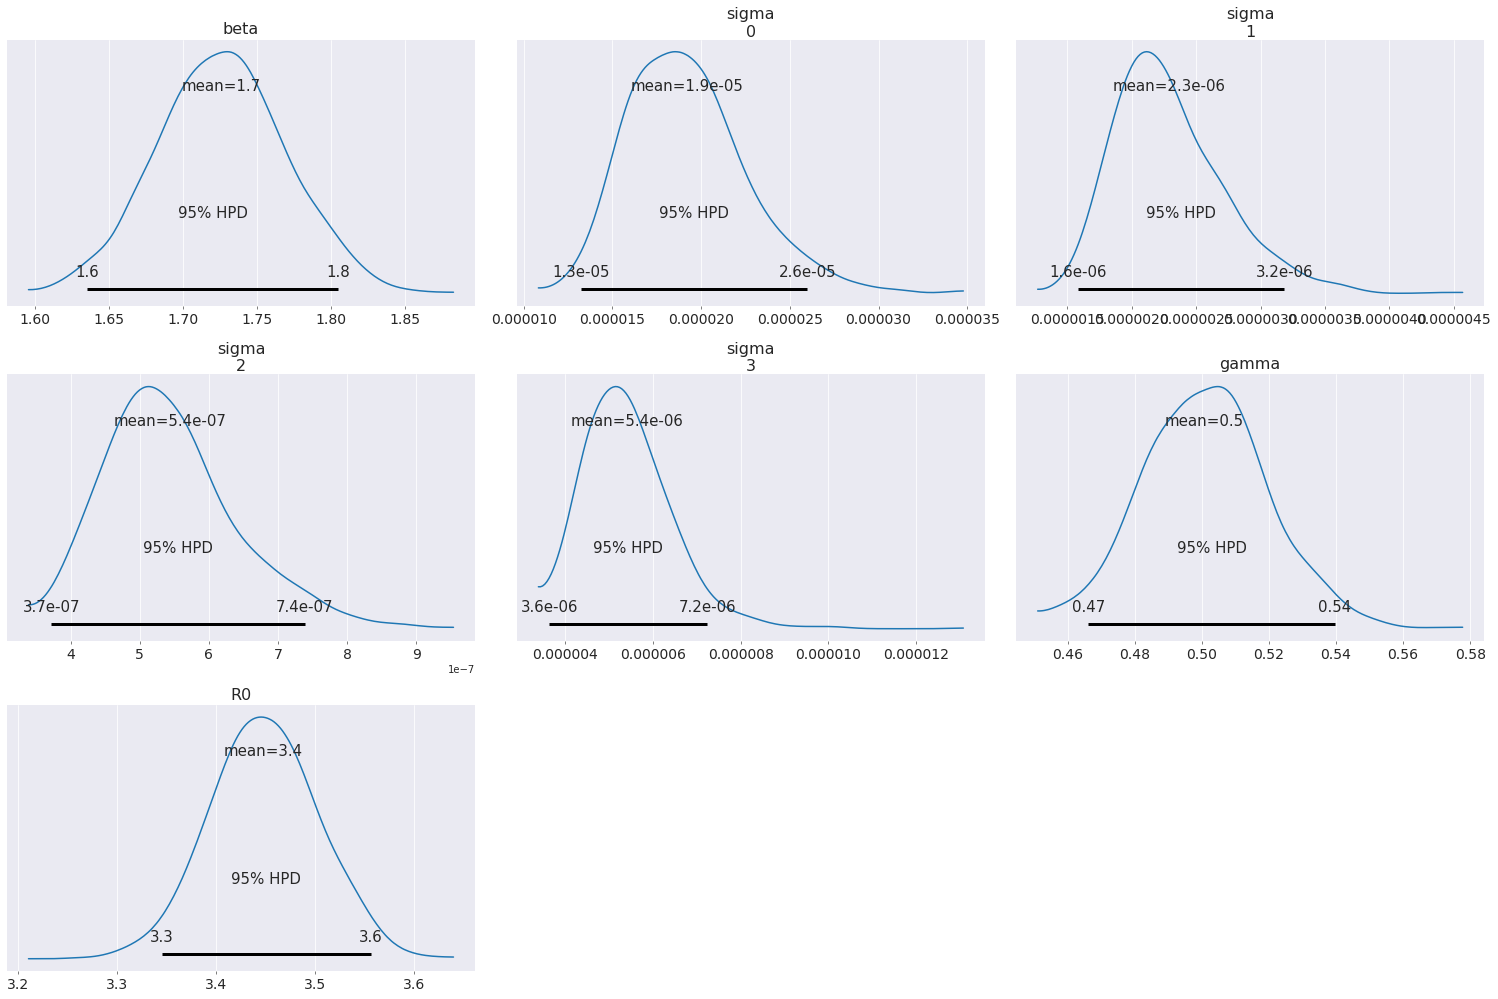

In [0]:
az.plot_posterior(data,round_to=2, credible_interval=0.95);


In [0]:
#Crear intervalos de confianza para los parametros encontrados
ppc_samples = posterior_predictive["Y"]
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)


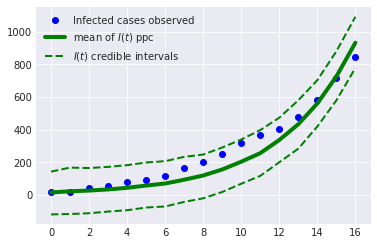

In [0]:
## Curva del modelo con los parametros estimados R0 y beta y datos 
plt.plot(obs_times,yobs,'o', color='b', lw=1, label='Infected cases observed')
plt.plot(obs_times,mean_ppc[:,2]*Pop, color='g', lw=4, label=f'mean of $I(t)$ ppc')
plt.plot(obs_times,CriL_ppc[:,2]*Pop, '--',  color='g', lw=2, label=f'$I(t)$ credible intervals')
plt.plot(obs_times,CriU_ppc[:,2]*Pop, '--',  color='g', lw=2)
plt.savefig('model-4')
plt.legend()

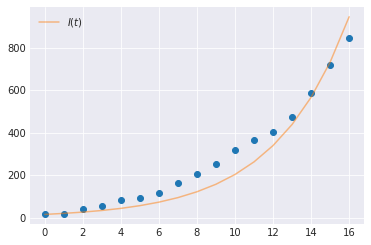

In [0]:
## Curva de modelo con parametros fiteados

times = np.arange(0,180,1) # 90 dias

## Condiciones iniciales (porcentuales)
Pop = 126577691  # Mexico Nacional https://es.wikipedia.org/wiki/Demograf%C3%ADa_de_M%C3%A9xico
I_o = IR['Casos'][0] / Pop  # Tenemos 32 casos
E_o = (IR['Casos'][0]*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado


## Curva de modelo vs. observaciones
y = odeint(SEIR,t=times,y0=[S_o,E_o,I_o,R_o], args=((p_alpha, data.posterior.beta.median(), data.posterior.gamma.median()),), rtol=1e-08)


yobs = IR['Casos'].to_numpy()

## Fit de primeras 5 observaciones
plt.plot(yobs, marker='o', linestyle='none')
plt.plot(y[:len(yobs),2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [0]:
#az.plot_ppc(data)

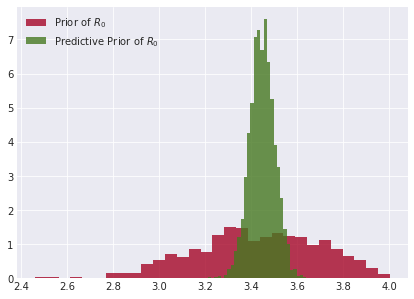

In [0]:
plt.figure(figsize = (7,5))
plt.hist(prior["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $R_0$",color = "#A60628", density = True)
plt.hist(trace["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $R_0$",color = "#467821", density = True)
plt.legend()

In [0]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,1.726,0.043,1.641,1.805,0.001,0.001,1107.0,1107.0,1103.0,917.0,1.0
sigma[0],0.000,0.000,0.000,0.000,0.000,0.000,1890.0,1737.0,2023.0,1335.0,1.0
sigma[1],0.000,0.000,0.000,0.000,0.000,0.000,1657.0,1467.0,1943.0,1162.0,1.0
sigma[2],0.000,0.000,0.000,0.000,0.000,0.000,1437.0,1337.0,1660.0,1229.0,1.0
sigma[3],0.000,0.000,0.000,0.000,0.000,0.000,1308.0,1075.0,1688.0,952.0,1.0
gamma,0.501,0.019,0.466,0.537,0.001,0.000,1138.0,1138.0,1134.0,892.0,1.0
R0,3.447,0.055,3.345,3.548,0.001,0.001,1482.0,1474.0,1490.0,1137.0,1.0
